## Low-res digits dataset

We'll try and replicate some of the classification tasks we did for MNIST with the digits dataset.

Exercise. Implement a Binary classifier able to <b>recognize the 8 digit</b>:
* 1. load the digits dataset (done for you)
* 2. have a look the digits dataset
* 3. split train and test set
* 4. prepare the data for the model training
* 5. train 3 models in cross-validation and plot the ROC curves. The three models are:
    * an SGD classifier fitting a linear support vector machine
    * a 7-Nearest Neighbour classifier
    * a (non-linear) support vector machine
    
Which is the most performant, if evaluated using a ROC curve? Which one of the three would you choose?

## Setup

In [106]:
# Python ≥3.8 is required
import sys
assert sys.version_info >= (3, 8)

# Scikit-Learn ≥1.0 is required
import sklearn
assert sklearn.__version__ >= "1.0"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from time import time

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 1. Load the FashionMNIST dataset

In [107]:
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True, as_frame=False)

In [108]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [109]:
X.shape

(1797, 64)

8 x 8 pixels (instead of 28 x 28 pixels)

In [110]:
y.shape

(1797,)

# 2. Have a look at the dataset

In [111]:
df = pd.DataFrame(X)
df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,4.0,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0


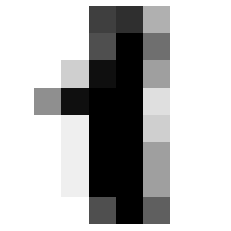

In [48]:
digit = X[1]
digit_img = digit.reshape(8, 8)

plt.imshow(digit_img, cmap='binary')
plt.axis('off')
plt.show()

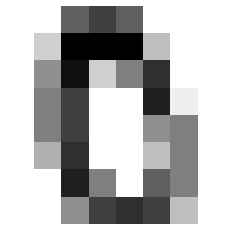

In [49]:
digit = X[78]
digit_img = digit.reshape(8, 8)

plt.imshow(digit_img, cmap='binary')
plt.axis('off')
plt.show()

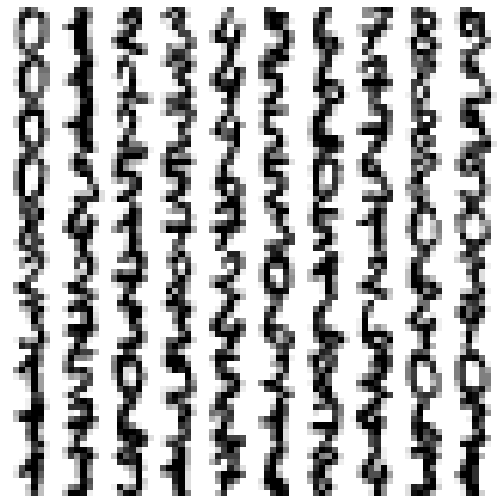

In [50]:
plt.figure(figsize=(9,9))
example_images = X[:100]
show_digits(example_images, images_per_row=10)
plt.show()

### A couple of useful functions

In [38]:
def show_digits(instances, size=8, images_per_row=10, **opts):
    """
    Utility function to display the MNIST digits on a grid
    """
    images_per_row = min(len(instances), images_per_row)
    # convert images from 1-D to 2-D arrays
    images = [instance.reshape(size, size) for instance in instances]
    # compute how many rows you need in the grid
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    # create empty "dummy" images to fill potential remaining slots at the end of the grid
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    # concatenate all the images in a single grid image
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    # plot the grid image
    plt.imshow(image, cmap = mpl.cm.binary, **opts)
    plt.axis("off")

# 2.5. Shuffle?

Should we shuffle the numbers? This was raised in 4.1... but what about <b>y</b>? that won't match...

[EDIT] - it seems that the latter rows are shuffled...

In [40]:
X_shuffle = X
np.random.shuffle(X_shuffle)

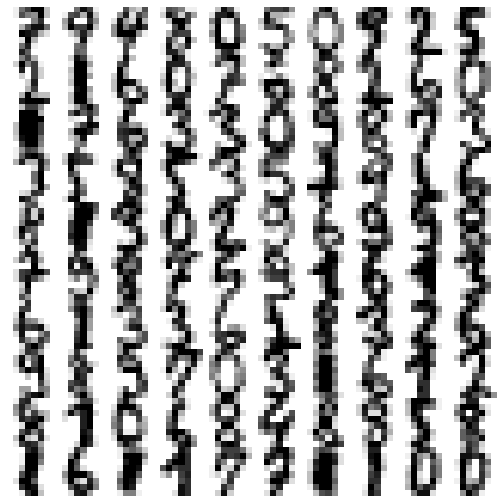

In [41]:
plt.figure(figsize=(9,9))
example_images = X_shuffle[:100]
show_digits(example_images, images_per_row=10)
plt.show()

# 3. Split Train and Test set

In [51]:
# use slicing to create training and test set
X_train, X_test, y_train, y_test = X[:1000], X[1000:], y[:1000], y[1000:]

In [52]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1000, 64), (797, 64), (1000,), (797,))

# 4. Preparation for training

start with a binary classifier for recognising the digit 8

In [56]:
y_train_8 = y_train == 8
y_test_8 = y_test == 8

In [57]:
y_train_8[:20], y_train[:20]

(array([False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
         True, False]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [58]:
df = pd.DataFrame(y_train_8[:20], y_train[:20])
df

,0
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,True
9,False


# 5. Train three models with Cross Validation and plot the ROC Curves

The three models are:
1. an SGD classifier fitting a linear support vector machine
2. a 7-Nearest Neighbour classifier
3. a (non-linear) support vector machine

# 5.1. SGD Classifier with a linear support vector machine (SVM)

In [63]:
from sklearn.linear_model import LogisticRegression
lin_cl = LogisticRegression()
lin_cl.fit(X_train, y_train_8)

/Users/nick/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [64]:
from sklearn.linear_model import SGDClassifier

sgd_cl = SGDClassifier(random_state=77, loss="log")
sgd_cl.fit(X_train, y_train_8)

SGDClassifier(loss='log', random_state=77)

In [65]:
sgd_cl.predict(X_train[:20])

array([False, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
        True, False])

In [66]:
y_train[:20]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Cross Validation 

In [67]:
from sklearn.model_selection import cross_val_score

import time
start_time = time.time()

scores = cross_val_score(
    sgd_cl, X_train, y_train_8, cv=3, scoring="accuracy"
)
print("--- %s seconds ---" % (time.time() - start_time))
#%time

--- 0.024485111236572266 seconds ---


In [68]:
scores

array([0.93113772, 0.89189189, 0.94294294])

In [69]:
np.mean(scores)

0.9219908531285776

### Cross Val + Support Vector Machines (SVM)

In [70]:
from sklearn.svm import SVC
svm_cl = SVC(gamma='auto')
#start = time()
#svm_cl.fit(X_train[:1000], y_train[:1000])
#print('Duration: {} s'.format(time() - start))
#svm_cl.predict(X_train[:10])


import time
start_time = time.time()

from sklearn.model_selection import cross_val_score
start = time.time()
scores = cross_val_score(
    svm_cl, # model we want to train
    X_train[:10000], # features
    y_train_8[:10000], # labels
    scoring='accuracy', # accuracy
    cv=5 #cross val checks (should be 5)
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.3723430633544922 seconds ---


### Precision, Recall and F1 score

In [72]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(
    sgd_cl,
    X_train,
    y_train_8,
    cv=3
)
y_train_pred

array([False, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [73]:
from sklearn.metrics import precision_score, recall_score, f1_score
ps = precision_score(y_train_8, y_train_pred)
rs = recall_score(y_train_8, y_train_pred)
f1s = f1_score(y_train_8, y_train_pred)
ps, rs, f1s

(0.5961538461538461, 0.6326530612244898, 0.6138613861386137)

In [74]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(
    sgd_cl,
    X_train,
    y_train_8,
    cv=3
)
y_train_pred

array([False, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [75]:
from sklearn.metrics import roc_curve

import time
start_time = time.time()

y_scores_sgd = cross_val_predict(
    sgd_cl, # our SGD classifier trained to fit a Logistic Regressor
    X_train,
    y_train_8,
    cv=3,
    method='decision_function'
)

fpr, tpr, thresholds = roc_curve(y_train_8, y_scores_sgd)

print("--- %s seconds ---" % (time.time() - start_time))


--- 0.0189969539642334 seconds ---


In [77]:
confusion_matrix(y_train_8, y_train_pred)

array([[860,  42],
       [ 36,  62]])

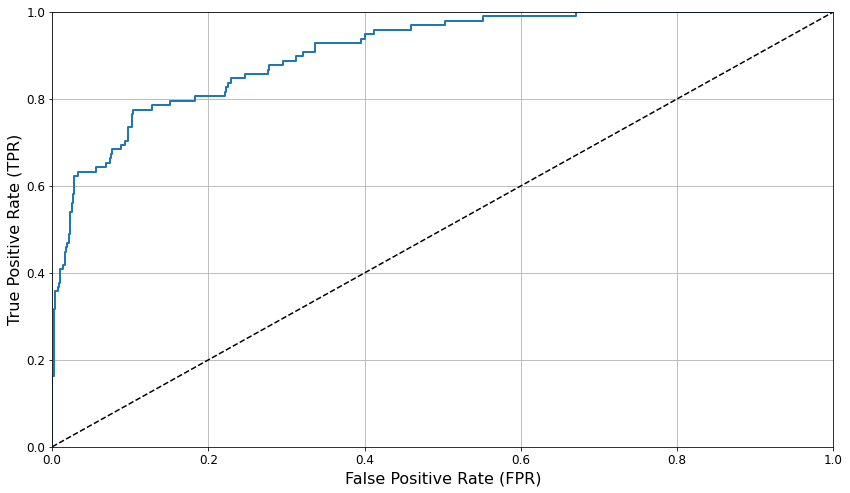

In [78]:
plt.figure(figsize=(14, 8))
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)
    plt.grid(True)
plot_roc_curve(fpr, tpr)
plt.show()

In [79]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_8, y_scores_sgd)

0.9083216435132812

# 5.2. Seven (7) Nearest Neighbours


In [80]:
from sklearn.neighbors import KNeighborsClassifier

import time
start_time = time.time()

kn_cl = KNeighborsClassifier(n_neighbors=7)
y_probs_kn = cross_val_predict(
    kn_cl,
    X_train,
    y_train_8,
    cv=3, 
    method='predict_proba'
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.017618179321289062 seconds ---


In [81]:
from sklearn.ensemble import RandomForestClassifier

import time
start_time = time.time()

forest_cl = RandomForestClassifier(
    n_estimators=100, # a "forest" of 100 decision trees
    random_state=77
)
y_probs_forest = cross_val_predict(
    forest_cl,
    X_train,
    y_train_8,
    cv=3,
    method="predict_proba"
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.30133914947509766 seconds ---


In [82]:
# Nearest neighbours scores
y_scores_kn = y_probs_kn[:, 1]    # score = proba of positive class
fpr_kn, tpr_kn, thresholds_kn = roc_curve(y_train_8, y_scores_kn)
# Random Forests scores
y_scores_forest = y_probs_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_8,y_scores_forest)

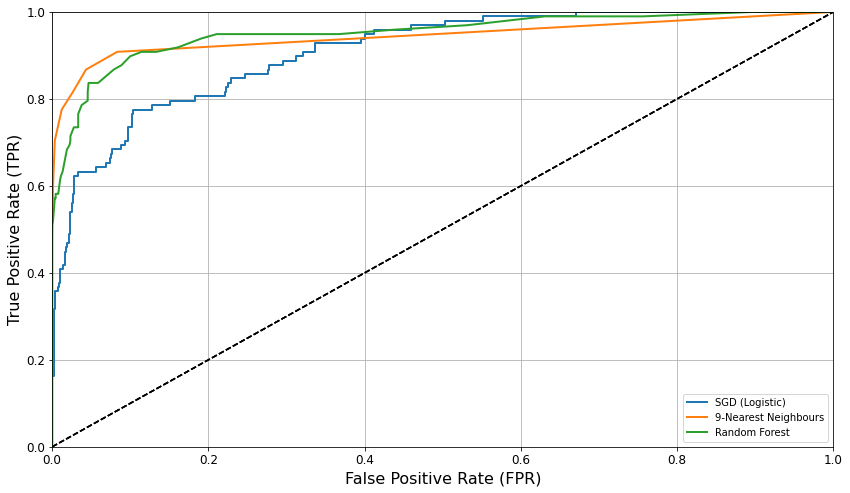

In [83]:
plt.figure(figsize=(14, 8))
plot_roc_curve(fpr, tpr, "SGD (Logistic)")
plot_roc_curve(fpr_kn, tpr_kn, "7-Nearest Neighbours")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [88]:
from sklearn.metrics import roc_auc_score

print("SGD: ", roc_auc_score(y_train_8, y_scores_sgd))
print("7-KN: ", roc_auc_score(y_train_8, y_scores_kn))
print("Random Forest: ", roc_auc_score(y_train_8, y_scores_forest))



SGD:  0.9083216435132812
7-KN:  0.944262183809222
Random Forest:  0.9508292230417664


As a general rule, prefer the Precision/Recall curve if the positive class is uncommon or if you worry more about the false positives rather than the false negatives. In the other scenarios, prefer the ROC curve.

# 5.3 a (non-linear / Logistic?) support vector machine

In [95]:
from sklearn.metrics import roc_curve

import time
start_time = time.time()

y_scores_sgd = cross_val_predict(
    sgd_cl, # our SGD classifier trained to fit a Logistic Regressor
    X_train,
    y_train_8,
    cv=3,
    method='decision_function'
)

#print(y_scores_sgd)

fpr, tpr, thresholds = roc_curve(y_train_8, y_scores_sgd)

#print("--- %s seconds ---" % (time.time() - start_time))

[-3856.98679943 -1465.50085501  -617.24290604 -2766.83936327
 -1800.3598534  -2293.84544312   111.11670113 -4538.96396717
  1786.26772571  -587.43621108 -2964.00192864  -885.03617483
 -3161.67715995 -3092.44546648 -2709.42035703 -4035.55113608
 -2697.75691515 -2127.88073118 -1798.54798019 -4394.31530365
 -2305.8808195  -1609.3183668  -2791.78219306 -3430.82193308
  -952.90852307 -2959.60355389 -1602.06325492 -3794.61556991
  1365.11081466 -3943.80715482 -4202.15399644 -4019.88037935
 -5828.05468898 -3510.26740246  -437.26115407 -3065.09614829
 -2330.02313659 -3049.13760082 -2005.82880504 -2987.81858341
   376.20364998 -2758.81296643 -1321.90471009 -3161.4073105
 -5696.91092893 -5435.71712579 -1228.60098586 -1541.41997428
 -4068.0103131  -3837.44455831  -590.92460002 -1864.42185692
 -5533.20785893 -1321.72743578 -1506.42488849 -3881.50646031
 -1668.35385194  -194.09894008   595.37399522 -1975.60513118
 -4853.75199687 -2936.59946431 -4989.0119443  -4060.31171455
 -5521.05753583  -864.110

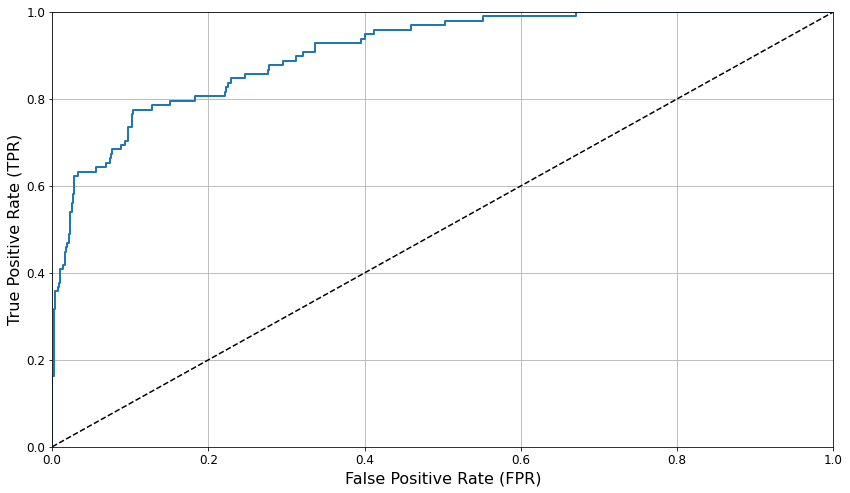

In [90]:
plt.figure(figsize=(14, 8))
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)
    plt.grid(True)
plot_roc_curve(fpr, tpr)
plt.show()

In [102]:
from sklearn.svm import SVC
svm_cl = SVC(gamma='auto')
#start = time()
#svm_cl.fit(X_train[:1000], y_train[:1000])
#print('Duration: {} s'.format(time() - start))
#svm_cl.predict(X_train[:10])


import time
start_time = time.time()

from sklearn.model_selection import cross_val_score
start = time.time()

y_scores_log_svm = cross_val_predict(
    svm_cl, # model we want to train
    X_train[:10000], # features
    y_train_8[:10000], # labels
    cv = 3, 
    method='decision_function'
)
y_scores_log_svm

fpr_svm, tpr_svm, thresholds = roc_curve(y_train_8, y_scores_log_svm)

#print("--- %s seconds ---" % (time.time() - start_time))

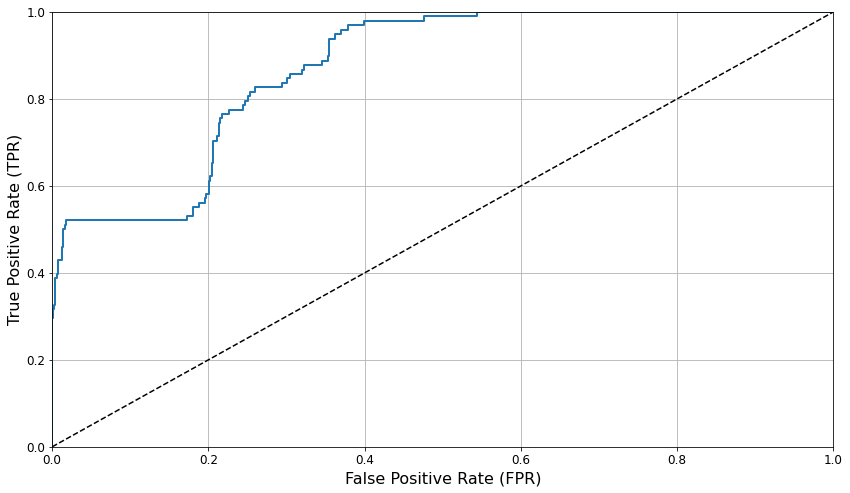

In [103]:
plt.figure(figsize=(14, 8))
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)
    plt.grid(True)
plot_roc_curve(fpr, tpr)
plt.show()

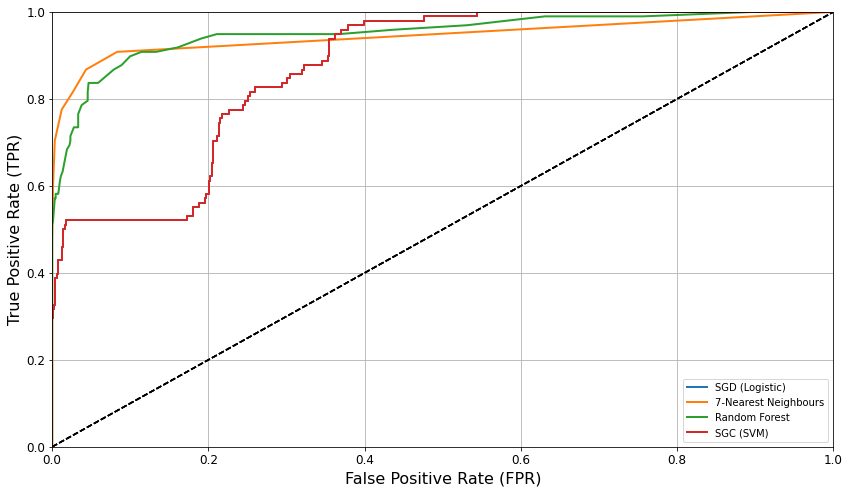

In [104]:
plt.figure(figsize=(14, 8))
plot_roc_curve(fpr, tpr, "SGD (Logistic)")
plot_roc_curve(fpr_kn, tpr_kn, "7-Nearest Neighbours")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_svm, tpr_svm, "SGC (SVM)")
plt.legend(loc="lower right")
plt.show()

In [105]:
from sklearn.metrics import roc_auc_score

print("SGD: ", roc_auc_score(y_train_8, y_scores_sgd))
print("7-KN: ", roc_auc_score(y_train_8, y_scores_kn))
print("Random Forest: ", roc_auc_score(y_train_8, y_scores_forest))
print("SGC (SVM): ", roc_auc_score(y_train_8, y_scores_log_svm))


SGD:  0.9083216435132812
7-KN:  0.944262183809222
Random Forest:  0.9508292230417664
SGC (SVM):  0.8704805647314358
